# Build a TextCNN  model

In this notebook, we are going to build a Convolutional Neural Network model according to the following paper: https://arxiv.org/pdf/1408.5882.pdf. The model will be trained on the top of the pre-trained Glove embeddings.

#### Convolution

Convolutional neural networks  (CNN)  utilize layers with convolving features detectors, also referred to as kernels or filters that are applied to the input image or previous convolution layer output. The filter moves through the entire image with the stride of 1, at each step the element-wise multiplication and then the sum is calculated between all the values of the image that are encompassed by the current kernel position and the filters values. The map that results from that operation is called the feature map. By using different kernels we can obtain many feature maps that will build the convolutional layer.

By applying the feature detector, we:
- get rid of some unnecessary information,
- can reduce the size of the image,
- detect features,
- take into consideration that given features can appear in a different part of the image.
<br>
<br>
<div>
<img src="assets/An-example-of-convolution-operation-in-2D-2.png" width="450" />
</div>
<p style='text-align: center;'>Convolution operation [by Ihab S. Mohamed, https://www.researchgate.net/figure/An-example-of-convolution-operation-in-2D-2_fig3_324165524]</p>

#### ReLU layer

On top of the convolutional layer, we have to apply the ReLU function to increase the non-linearity in our model. Feature detectors can contain negative values, so to get rid of them and at the same time prevent the model from interpreting changes from positive to negative values in our image as linear dependant we will apply the ReLU function.

#### Max Pooling layer

Spatial invariance is the feature of neural network thanks to which the model is capable of recognizing the same features even if they are a bit different, have different texture, shape or orientation. The max-pooling operation simply takes the maximum value from the max-pooling box that is applied to the feature map. High numbers on the feature map are representing the high similarity to given feature, so by taking the maximum values we will get rid of irrelevant features, and at the same time because we take the maximum from for example the 2x2 box we enable spatial invariance of the model because it doesn't matter if the feature is located on the top left corner or bottom right corner of the max-pooling box we still are able to extract that feature.
<br>
<br>
<div>
<img src="assets/MaxpoolSample2.png" width="400" />
</div>
<p style='text-align: center;'>Max-pooling operation with kernel of size 2x2 and stride of 2 [https://computersciencewiki.org/index.php/Max-pooling_/_Pooling]</p>

<br>

#### Model's architecture
<div>
<img src="assets/TextCNN_schema.png" width="950" />
</div>

The convolution layer consists of feature maps that are created based on the input word embeddings by performing convolution operations using multiple filter sizes. Using different kernel sizes enable the model to find different features (n-grams). Next, the adaptive max-pooling is applied to the convolving output after going through the ReLU activation function. Max-pooled tensors are concatenated and pass on to the dropout layer, and then to the linear layer.

### Building and training the model

Let's start with importing all indispensable libraries.

In [29]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Now, we are going to load the tarining and validation sets, but we will use only the clean_review column and label column.

In [30]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('dataset/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= 5
train_dataset = train_dataset[['clean_review', 'label']]

In [31]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,label
2,young suffering severe extreme neck pain resul...,True
5,found work helping good nights sleep don&#039;...,True
9,given medication gastroenterologist office wor...,False
12,recently laparoscopic hysterectomy know anesth...,True
13,mirena year experienced effects effects watch ...,False


In [32]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('dataset/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
val_dataset['label'] = val_dataset.rating >= 5
val_dataset = val_dataset[['clean_review', 'label']]

In [33]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna()
val_dataset.head()

,clean_review,label
0,year old son took night went deep sea fishing ...,True
1,daughter epiduo grade junior year work wonders...,True
2,i&#039;ve implant months day got totally felt ...,True
3,wanted wait days post couldn&#039;t results am...,True
4,colonoscopy best prep far morning took prep pm...,True


Below we will use the BatchIterator class defined in the *vocabulary* notebook to create the vocabulary, trim sequences in terms of the rare word occurrence and the length, map words to their numerical representation (word2index), furthermore BatchIterator sorts dataset examples, generates batches, performs sequence padding and enables to use it instance to iterate through all batches.

To create the weights matrix we have to set use_pretrained_vectors=True and supply the weight file path, Glove vectors file name and the directory and the name of the file to which we will export the prepared weights matrix. To use different word embeddings, simply pass on their file to the BatchIterator class.

In [34]:


train_iterator = BatchIterator(train_dataset, batch_size=128, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.7,
                               use_pretrained_vectors=True, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
8674/21861 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 47
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 7686/8678 of pre-trained word vectors.
992 vectors initialized to random numbers
Weights vectors saved into glove/weights.npy
Batches created


In [35]:
val_iterator = BatchIterator(val_dataset, batch_size=128, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.7, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
4655/11853 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 46
Mapped words to indices
Batches created


We have to check out how batches that we created look like before we pass them into the model. For the record, the set of batches for input and output variables is returned as a dictionary, thus we will just look at the dictionary keys to find out how to extract particular variables.

In [36]:
for batches in train_iterator:
    print(batches.keys())
    break

dict_keys(['input_seq', 'target', 'x_lengths'])


Notice that the output batch has the dimensions: (batch_size, seq_len)

In [37]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([128, 13])
target shape:  torch.Size([128])
x_lengths shape:  torch.Size([128])


In [38]:
for batches in val_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([128, 37])
target shape:  torch.Size([128])
x_lengths shape:  torch.Size([128])


Next step is to build the TextCNN model.

In [61]:
class TextCNN(nn.Module):
    """Text Convolutional Neural Network.
        
    Parameters
    ----------
    conv_config: dict
        Dictionary of convolution layer settings (keys: 'num_channels', 'kernel_sizes')
        Number of channels corresponds to the number of filters.
    weight_matrix: numpy.ndarray
        Matrix of pre-trained word embeddings.
    output_size: int
        Number of classes.
    dropout: float, optional (default=0.5)
        Probability of an element of the tensor to be zeroed.

    """
    
    def __init__(self, conv_config, weights_matrix, output_size, dropout=0.5):
        
        # Inherit everything from the nn.Module
        super(TextCNN, self).__init__()
        
        # Initialize attributes
        self.conv_config = conv_config
        self.output_size = output_size
        self.weights_matrix = weights_matrix
        self.dropout_p = dropout
        self.vocab_size, self.embedding_dim = self.weights_matrix.shape
        
        # Initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # Load the weights to the embedding layer
        self.embedding.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
        self.embedding.weight.requires_grad = False          
            
        self.convolutions = nn.ModuleList([nn.Sequential(
            nn.Conv1d(self.embedding_dim, self.conv_config['num_channels'], kernel_size=kernel),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d((1,)))\
                         for kernel in self.conv_config['kernel_sizes']])    
            
        self.dropout = nn.Dropout(self.dropout_p)    
        self.linear = nn.Linear(self.conv_config['num_channels'] * len(self.conv_config['kernel_sizes']),\
                                                                       self.output_size)

        
    def forward(self, input_seq):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """        
        # Embeddings shapes
        # Input: (batch_size,  seq_length)
        # Output: (batch_size, embedding_dim, seq_length)
        emb_out = self.embedding(input_seq).permute(0,2,1)

        # Conv1d -> Relu -> AdaptiveMaxPool1d
        # Input: (batch_size, embedding_dim, seq_length)
        # Output: (batch_size, num_channels)
            
        conv_out = [conv(emb_out).squeeze(2) for conv in self.convolutions]       

        # Concatenate the list of convolving outputs from the previous step
        concat_out = torch.cat(conv_out, dim=1)

        concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)
        return F.log_softmax(out, dim=-1)
    
    
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix


Now we will instantiate the model, add loss function, optimizer, and device to it and begin the training.

In [57]:
# Initialize parameters
conv_config = {'num_channels': 50, 'kernel_sizes': [1,2]}
output_size = 2
learning_rate = 0.001
epochs = 50
dropout = 0.8

# Load the weights matrix
weights = np.load('glove/weights.npy')

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = TextCNN(conv_config, weights, output_size, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

model.add_loss_fn(nn.NLLLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)
    
    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_accuracy)
    
    _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)
    
    eval_avg_loss_list.append(eval_avg_loss)
    eval_accuracy_list.append(eval_accuracy)
    conf_matrix_list.append(conf_matrix)
    
    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))
    
    if early_stop.stop(eval_avg_loss, model, delta=0.003):
        break

    


Start epoch [1/50]


Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1]

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1]

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1]

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1]

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1]

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 6]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

Training:   0%|          | 0/113 [00:00<?, ?it/s]

print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 13]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 43]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 36]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 12]) torch.Size([128, 50, 1])

print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 15]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 46]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 32]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 48]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 24]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 26]) torch.Size([128, 50, 1

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 37]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 47]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 19]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 11]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 30]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 14]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 7]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 9]) torch.Size([128, 50, 1])
print: torch.Size([128, 100, 28]) torch.Size([128, 50, 1])
p

In [58]:
# Add the dataset initial loss
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

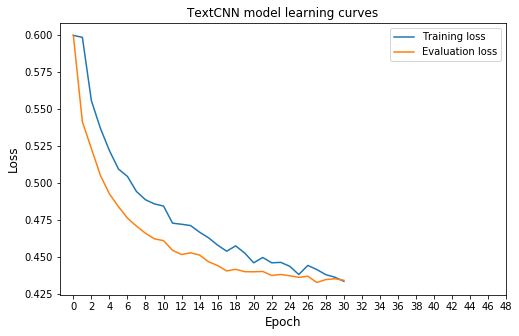

In [59]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('TextCNN model learning curves')
plt.xticks(ticks=range(0,49,2))
plt.legend()
plt.show()

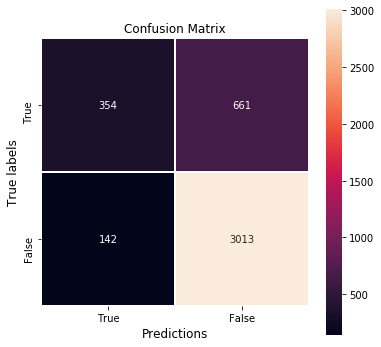

In [60]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The model achieved the validation accuracy of 0.847, while the training accuracy was 0.833. The model's best state was saved to the *checkpoint.pt* file in the current directory.

### The generalization error

In [63]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('dataset/drugreview_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
test_dataset['label'] = test_dataset.rating >= 5
test_dataset = test_dataset[['clean_review', 'label']]

In [66]:
test_dataset = test_dataset.dropna()
test_dataset.head()

,clean_review,label
2,given sample doctor mg hours lower abdominal g...,False
3,given medication post hysteroscopy suffered se...,True
4,loperamide helpful diarrhea fewer caplets help...,True
10,use claritin d seasonal allergies started taki...,True
15,worked immediate effects noticeable long term,True


In [67]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
3069/8377 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 54
Mapped words to indices
Batches created


In [68]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

print: torch.Size([256, 100, 20]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 20]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 27]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 27]) torch.Size([256, 50, 1])
print: torch.Size([45, 100, 4]) torch.Size([45, 50, 1])
print: torch.Size([45, 100, 4]) torch.Size([45, 50, 1])
print: torch.Size([256, 100, 13]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 13]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 55]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 55]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 48]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 48]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 54]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 54]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 41]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 41]) torch.Size([256, 50, 1])
print: torch.Size([256, 100, 33]) torch.Size([256, 50, 1])
pri

In [69]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.803. Test error: 0.441


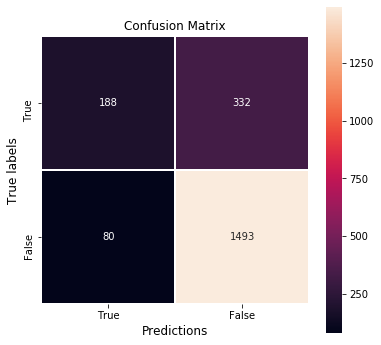

In [70]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The generalization accuracy of the TextCNN model is 0.803. As we can see in the above plot of the confusion matrix the number of False negative predictions (332) is greater than the amount of False positive predictions (80) which is good.